In [1]:
import mmf_setup;mmf_setup.nbinit()
import matplotlib.pyplot as plt
%pylab inline --no-import-all
from nbimports import *
import numpy as np

<IPython.core.display.Javascript object>

# Define Some Helper Functions

In [2]:
from mmf_hfb.BCSCooling import BCSCooling
from mmf_hfb.SolverABM import ABMEvolverAdapter
from mmf_hfb.Cooling import Cooling
from mmf_hfb.Potentials import HarmonicOscillator
from IPython.display import display, clear_output
import time
np.random.seed(1)

def Normalize(psi, dx=0.1):
    return psi/(psi.dot(psi.conj())*dx)**0.5

def Prob(psi):
    return np.abs(psi)**2
   
def check_uv_ir_error(x, psi, plot=False):
    """check if a lattice configuration(N, L, dx) is good"""
    psi_k = np.fft.fft(psi)
    psi_log = np.log10(abs(psi))
    psi_log_k = np.log10(abs(psi_k))
    if plot:
        l, =plt.plot(x,psi_log_k)
        plt.plot(x, psi_log,'--', c=l.get_c())
        print(np.min(psi_log), np.min(psi_log_k))
    assert np.min(psi_log_k) < -15

# Lattice Configuration

-17.7887019787572 -inf


c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


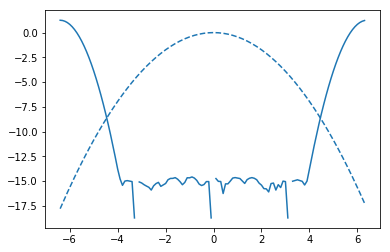

In [3]:
N, dx = 128, 0.1
args = dict(N=N, dx=dx, divs=(1, 1), beta0=1, beta_K=0, beta_V=0, beta_D=0, beta_Y=0, T=0, check_dE=False)
b = BCSCooling(**args)
x = b.xyz[0]
gaussian = np.exp(-x**2)
check_uv_ir_error(x=x, psi=gaussian, plot=True)

# Compute Ground State
* For any potential $V$, and any interaction $g$

In [4]:
def get_ground_state(V, **args):
    b = BCSCooling(**args)
    x = b.xyz[0]
    H = b._get_H(mu_eff=0, V=V)
    U, E = b.get_U_E(H, transpose=True)
    return Normalize(U[0], dx=b.dx)

def random_gaussian_mixing(x):
    n = np.random.randint(1, 10)
    cs = np.random.random(n)
    ns = np.random.randint(1, 10, size=n)
    
    ys = sum([c*np.exp(-x**2/n**2) for (c, n) in zip(cs, ns)])
    return Normalize(ys)

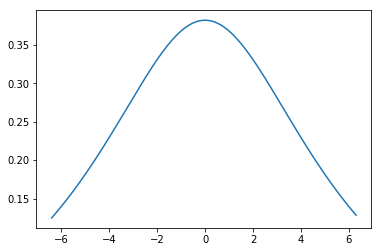

In [5]:
y = random_gaussian_mixing(x)
plt.plot(x,y)

# Check Upper-Bound
* Roughly check the max value of $\beta_0$, $\beta_V$, $\beta_K$, $\beta_D$, $\beta_Y$

In [6]:
beta_V=60
beta_K=75
beta_D=1000
beta_Y=1

# List of Cooling Configuration

In [7]:
cooling_para_list=[dict(beta_V=beta_V, beta_K=beta_K, beta_D=beta_D, beta_Y=beta_Y),
             dict(beta_V=beta_V, beta_K=beta_K, beta_D=beta_D, beta_Y=0),
             dict(beta_V=beta_V, beta_K=beta_K, beta_D=0, beta_Y=beta_Y),
             dict(beta_V=beta_V, beta_K=0, beta_D=beta_D, beta_Y=beta_Y),
             dict(beta_V=0, beta_K=beta_K, beta_D=beta_D, beta_Y=beta_Y),
             dict(beta_V=beta_V, beta_K=beta_K, beta_D=0, beta_Y=0),
             dict(beta_V=beta_V, beta_K=0, beta_D=beta_D, beta_Y=0),
             dict(beta_V=0, beta_K=beta_K, beta_D=beta_D, beta_Y=0),
             dict(beta_V=beta_V, beta_K=0, beta_D=0, beta_Y=beta_Y),
             dict(beta_V=0, beta_K=beta_K, beta_D=0, beta_Y=beta_Y),
             dict(beta_V=0, beta_K=0, beta_D=beta_D, beta_Y=beta_Y),             
             dict(beta_V=0, beta_K=beta_K, beta_D=0, beta_Y=0),
             dict(beta_V=0, beta_K=0, beta_D=beta_D, beta_Y=0),
             dict(beta_V=0, beta_K=0, beta_D=0, beta_Y=beta_Y),    
             dict(beta_V=beta_V, beta_K=0, beta_D=0, beta_Y=0),
]

## List of Potentials

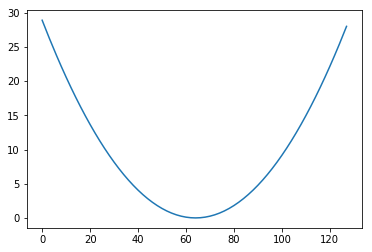

In [8]:
args = dict(N=N, dx=dx)
V0 = 0*x
V_HO = x**2/2
V_PO = V0 + np.random.random()*V_HO +  + abs(x**2)*np.random.random()
Vs = [0, V_HO, V_PO]
plt.plot(V_PO)

In [9]:
class TestCase(object):
    def __init__(self, V, g, N, dx, eps=1e-2, psi=None, max_T=10, **args):
        args.update(g=g, N=N, dx=dx)
        self.b = BCSCooling(**args)
        self.x = b.xyz[0]
        self.V = V
        self.eps = eps
        self.max_T = max_T
        self.g = g
        self.N = N
        self.dx = dx
        self.psi = psi if psi is not None else random_gaussian_mixing(self.x)
        self.psi0 = self.get_ground_state()       
        
    def get_ground_state(self):
        b = self.b
        H = b._get_H(mu_eff=0, V=self.V)
        U, E = b.get_U_E(H, transpose=True)
        psi0 = Normalize(U[0], dx=b.dx)
        self.psi_0 = psi0
        if self.g == 0:            
            return psi0
        else:
            # imaginary cooling
            for T in range(2, 10, 1):
                print(f"Imaginary Cooling with T={T}")
                ts, psiss = b.solve([psi0], T=5, beta_0=-1j, V=self.V, solver=ABMEvolverAdapter)
                psis = psiss[0]
                assert len(psis) > 2
                E1, _ = b.get_E_Ns([psis[-1]], V=self.V)
                E2, _ = b.get_E_Ns([psis[-2]], V=self.V)
                print((E2 - E1)/E1)
                if abs((E2 - E1)/E1)<1e-5:
                    return psis[-1]
            raise Exception("Failed to cool down to ground state.")

    def run(self):
        b = self.b
        E0, _ = b.get_E_Ns([self.psi0], V=self.V)
        print(f"E0={E0}")
        self.E0 = E0
        Ts = (np.array(list(range(10)))+1)*0.5
        args = dict(rtol=1e-5, atol=1e-6, V=self.V, solver=ABMEvolverAdapter)
        self.physical_time = []
        self.wall_time = []
        self.Es = []
        self.psis = []
        for T in reversed(Ts):
            start_time = time.time()
            ts, psiss = b.solve([self.psi], T=T, **args)
            wall_time = time.time()-start_time
            E, _ = b.get_E_Ns([psiss[0][-1]], V=self.V)           
            Es = [b.get_E_Ns([_psi], V=self.V)[0] for _psi in psiss[0]]
            self.wall_time.append(wall_time)
            self.physical_time.append(T)
            self.Es.append(E)
            self.psis.append(psiss[0][-1])
            print(f"physical time:{T}, wall time:{wall_time},dE:{(E-E0)/abs(E0)} ")
            if abs((E - E0)/E0) > self.eps:               
                break
    
    def plot(self, id=0):
        E=self.Es[id]
        psi = self.psis[id]
        plt.plot(self.x, Prob(psi), "--", label='init')
        plt.plot(self.x, Prob(self.psis[id]), '+', label="final")
        plt.plot(self.x, Prob(self.psi0), label='Ground')
        b=self.b
        plt.title(
            f"E0={self.E0:5.4},E={E:5.4}, $" + r"\beta_0$" +f"={b.beta_0}, "
            +r"$\beta_V$"+ f"={b.beta_V}, "+ r" $\beta_K$" + f"={b.beta_K}"
            +r" $\beta_D$" + f"={b.beta_D}"+ r" $\beta_Y$" + f"={b.beta_Y}")
        plt.legend()

In [10]:
psi_init = random_gaussian_mixing(x)
# args = dict(N=N, dx=dx, eps=1e-1, V=V_PO, beta_V=beta_V, g=1, psi=psi_init, check_dE=False)
# testCases = []
# t = TestCase(**args)
# t.run(plot=True)
# testCases.append(t)

In [11]:
psi_init = random_gaussian_mixing(x)
paras = []
for g in [0, 1]:
    for V in Vs:        
        for para in reversed(cooling_para_list):
            args = dict(N=N, dx=dx, eps=1e-1, V=V, beta_0=1, g=g, psi=psi_init, check_dE=False)
            args.update(para)
            paras.append(args)

In [12]:
from mmf_hfb.ParallelHelper import PoolHelper
def test_case_worker(para):
    t = TestCase(**para)
    t.run()
    return t
#res = PoolHelper.run(mqaud_worker_thread, paras=obj_twists_kp)

In [30]:
#t0 = test_case_worker(paras[40])

E0=0.5697378852647634
physical time:5.0, wall time:52.40199851989746,dE:878.6890051422336 


In [ ]:
# res = PoolHelper.run(test_case_worker, paras=paras)

In [14]:
testCases = []
for args in paras:
    t = test_case_worker(args)
    t.run()
    testCases.append(t)

E0=1.8740683821794332e-26


E:\Physics\quantum-fermion-theories\mmf-hfb\Docs\..\mmf_hfb\SolverABM.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  self.y = self.N*self.y/math.sqrt(self.y.conj().dot(self.y))


physical time:5.0, wall time:22.51208519935608,dE:6.622609696926509e+23 
E0=1.8740683821794332e-26
physical time:5.0, wall time:22.406883716583252,dE:6.622609696926509e+23 
E0=1.8740683821794332e-26
physical time:5.0, wall time:26.9910089969635,dE:7.642939789377701e+23 
E0=1.8740683821794332e-26
physical time:5.0, wall time:26.678138494491577,dE:7.642939789377701e+23 
E0=1.8740683821794332e-26
physical time:5.0, wall time:25.437098741531372,dE:2.6332028475960895e+28 
E0=1.8740683821794332e-26
physical time:5.0, wall time:25.290180921554565,dE:2.6332028475960895e+28 
E0=1.8740683821794332e-26
physical time:5.0, wall time:28.85017156600952,dE:7.642939787760339e+23 
E0=1.8740683821794332e-26
physical time:5.0, wall time:28.605241060256958,dE:7.642939787760339e+23 
E0=1.8740683821794332e-26
physical time:5.0, wall time:37.64585995674133,dE:2.6318466930851097e+28 
E0=1.8740683821794332e-26
physical time:5.0, wall time:38.101160526275635,dE:2.6318466930851097e+28 
E0=1.8740683821794332e-26
p

physical time:4.5, wall time:34.23937797546387,dE:0.002184697382974555 
physical time:4.0, wall time:29.76778769493103,dE:0.004327700944380843 
physical time:3.5, wall time:25.932300329208374,dE:0.008635558940434222 
physical time:3.0, wall time:22.26903772354126,dE:0.017443673291180135 
physical time:2.5, wall time:18.518235445022583,dE:0.0360392346378159 
physical time:2.0, wall time:14.769957304000854,dE:0.07729317348421808 
physical time:1.5, wall time:11.127872705459595,dE:0.17916636684627013 
E0=0.49999999999999983
physical time:5.0, wall time:37.37022137641907,dE:0.0011068240915331766 
physical time:4.5, wall time:33.4826283454895,dE:0.002184697382974555 
physical time:4.0, wall time:29.975800037384033,dE:0.004327700944380843 
physical time:3.5, wall time:26.095813274383545,dE:0.008635558940434222 
physical time:3.0, wall time:22.62335705757141,dE:0.017443673291180135 
physical time:2.5, wall time:18.563740491867065,dE:0.0360392346378159 
physical time:2.0, wall time:14.81541585

physical time:1.5, wall time:10.664793014526367,dE:0.06285960052227481 
physical time:1.0, wall time:7.1078126430511475,dE:2.343295471375175 
E0=0.594023136572134
physical time:5.0, wall time:41.09584426879883,dE:816.340005406955 
E0=0.594023136572134
physical time:5.0, wall time:40.10048294067383,dE:816.340005406955 
E0=0.594023136572134
physical time:5.0, wall time:33.44766902923584,dE:853.8665142418247 
E0=0.594023136572134
physical time:5.0, wall time:33.389116048812866,dE:853.8665142418247 
E0=0.594023136572134
physical time:5.0, wall time:36.95646142959595,dE:0.00039481558942339634 
physical time:4.5, wall time:34.38559412956238,dE:0.0008445248588815958 
physical time:4.0, wall time:30.63480281829834,dE:0.001809181195445439 
physical time:3.5, wall time:25.935065984725952,dE:0.0038911591800928347 
physical time:3.0, wall time:22.34545350074768,dE:0.008431229259311 
physical time:2.5, wall time:18.653130292892456,dE:0.018569422492878622 
physical time:2.0, wall time:14.80444049835

E:\Physics\quantum-fermion-theories\mmf-hfb\Docs\..\mmf_hfb\SolverABM.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  self.N = math.sqrt(y.conj().dot(y))


0.0
E0=0.03906250000000002
physical time:5.0, wall time:24.883939504623413,dE:0.6253752974514297 
E0=0.03906250000000002
physical time:5.0, wall time:25.068970918655396,dE:0.6253752974514297 
Imaginary Cooling with T=2
0.0
E0=0.039062500000000014
physical time:5.0, wall time:30.11455535888672,dE:0.8087438344939352 
E0=0.039062500000000014
physical time:5.0, wall time:29.640417098999023,dE:0.8087438344939352 
Imaginary Cooling with T=2
0.0
E0=493.5192825544682
physical time:5.0, wall time:29.017407178878784,dE:-6.910783939373358e-16 
physical time:4.5, wall time:25.718254566192627,dE:-6.910783939373358e-16 
physical time:4.0, wall time:22.97364091873169,dE:-6.910783939373358e-16 
physical time:3.5, wall time:20.27643370628357,dE:-6.910783939373358e-16 
physical time:3.0, wall time:17.103681087493896,dE:-6.910783939373358e-16 
physical time:2.5, wall time:15.62669849395752,dE:-6.910783939373358e-16 
physical time:2.0, wall time:11.913755655288696,dE:-6.910783939373358e-16 
physical time:

physical time:1.0, wall time:11.908871173858643,dE:0.004125216407112002 
physical time:0.5, wall time:5.977248430252075,dE:0.0007283944522615819 
E0=491.03213906016947
physical time:5.0, wall time:59.989407777786255,dE:0.0045746090366480235 
physical time:4.5, wall time:55.95734214782715,dE:0.004536179522439106 
physical time:4.0, wall time:49.36386060714722,dE:0.004497381873241675 
physical time:3.5, wall time:43.04716968536377,dE:0.004458206616260769 
physical time:3.0, wall time:35.621705293655396,dE:0.004418704825709012 
physical time:2.5, wall time:29.383687019348145,dE:0.004378877824174413 
physical time:2.0, wall time:23.7512264251709,dE:0.004338724342942116 
physical time:1.5, wall time:18.23875141143799,dE:0.004298218048474959 
physical time:1.0, wall time:11.769035816192627,dE:0.004125216407112002 
physical time:0.5, wall time:6.0930094718933105,dE:0.0007283944522615819 
Imaginary Cooling with T=2
-9.651350888631747e-07
E0=489.51758817831745
physical time:5.0, wall time:52.59

E:\Physics\quantum-fermion-theories\mmf-hfb\Docs\..\mmf_hfb\BCSCooling.py:423: RuntimeWarning: overflow encountered in square
  return sum(np.abs(psis)**2)
E:\Physics\quantum-fermion-theories\mmf-hfb\Docs\..\mmf_hfb\BCSCooling.py:206: RuntimeWarning: invalid value encountered in true_divide
  Hpsis = np.array(self.apply_H(psis, V=V))/(1j*self.hbar)
E:\Physics\quantum-fermion-theories\mmf-hfb\Docs\..\mmf_hfb\BCSCooling.py:357: RuntimeWarning: invalid value encountered in multiply
  +self.beta_K*Kc_psi + Vd_psis[i] + V_Dyadic_psis[i])
E:\Physics\quantum-fermion-theories\mmf-hfb\Docs\..\mmf_hfb\BCSCooling.py:390: RuntimeWarning: invalid value encountered in cdouble_scalars
  Hpsi -= psi.conj().dot(Hpsi)/psi.dot(psi.conj())*psi
E:\Physics\quantum-fermion-theories\mmf-hfb\Docs\..\mmf_hfb\SolverABM.py:89: RuntimeWarning: invalid value encountered in true_divide
  self.y = self.N*self.y/math.sqrt(self.y.conj().dot(self.y))
E:\Physics\quantum-fermion-theories\mmf-hfb\Docs\..\mmf_hfb\BCSCooling

nan
Imaginary Cooling with T=3
nan
Imaginary Cooling with T=4
nan
Imaginary Cooling with T=5
nan
Imaginary Cooling with T=6
nan
Imaginary Cooling with T=7
nan
Imaginary Cooling with T=8
nan
Imaginary Cooling with T=9
nan


Exception: Failed to cool down to ground state.

In [16]:
t0 = testCases[0]

In [19]:
t0.V

0

In [249]:
def show_des(t):
    b = t.b
    print(f"beta_0={b.beta_0} beta_V={b.beta_V} beta_K={b.beta_K} beta_D={b.beta_D} beta_Y={b.beta_Y}")
    print(t.E0, t.wall_time)
    print(f"{t.dE*100/t.E0}%100")
    
for t in testCases:
    show_des(t)

beta_0=1 beta_V=60 beta_K=0 beta_D=0 beta_Y=0
0.49999999999999983 11.861186504364014
1.3841292128746083%100
beta_0=1 beta_V=0 beta_K=0 beta_D=0 beta_Y=1
0.49999999999999983 58.09382939338684
6733.567722822036%100
beta_0=1 beta_V=0 beta_K=0 beta_D=1000 beta_Y=0
0.49999999999999983 53.005605936050415
200899.2188272922%100
beta_0=1 beta_V=0 beta_K=75 beta_D=0 beta_Y=0
0.49999999999999983 15.653366804122925
17.148426929599825%100
beta_0=1 beta_V=0 beta_K=0 beta_D=1000 beta_Y=1
0.49999999999999983 77.05473589897156
199920.15157483183%100
beta_0=1 beta_V=0 beta_K=75 beta_D=0 beta_Y=1
0.49999999999999983 31.350701570510864
1.6438239497996732%100
beta_0=1 beta_V=60 beta_K=0 beta_D=0 beta_Y=1
0.49999999999999983 18.840997457504272
1.2252863424865765%100
beta_0=1 beta_V=0 beta_K=75 beta_D=1000 beta_Y=0
0.49999999999999983 82.35269141197205
193850.78288054705%100
beta_0=1 beta_V=60 beta_K=0 beta_D=1000 beta_Y=0
0.49999999999999983 68.82430815696716
200899.21882729218%100
beta_0=1 beta_V=60 beta_K

In [246]:
def test_cooling(plot_dE=True, use_ABM=False, T=0.5, plt_log=True, **args):   
    b = BCSCooling(**args)
    solver = ABMEvolverAdapter if use_ABM else None
    h0 = HarmonicOscillator(w=1)
    h = HarmonicOscillator()
    da, db=b.divs    
    x = b.xyz[0]
    V = x**2/2
    H0 = b._get_H(mu_eff=0, V=0)
    H1 = b._get_H(mu_eff=0, V=V)
    U0, E0 = b.get_U_E(H0, transpose=True)
    U1, E1 = b.get_U_E(H1, transpose=True)
    psi0 = h.get_wf(x)
    psi0 = U1[0]
    psi0 = Normalize(psi0, dx=b.dx)
    psi = h0.get_wf(x, n=2)
    psi = random_gaussian_mixing(x) # U0[1]
    psi = Normalize(psi, dx=b.dx)
    #b.erase_max_ks()
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    N0 = psi0.conj().dot(psi0)
    ts, psiss = b.solve([psi], T=T, rtol=1e-5, atol=1e-6, V=V, solver=solver, method='BDF')
    E0, _ = b.get_E_Ns([psi0], V=V)
    Es = [b.get_E_Ns([_psi], V=V)[0] for _psi in psiss[0]]   
    plt.plot(x, Prob(psiss[0][0]), "+", label='init')
    plt.plot(x, Prob(psiss[0][-1]), '--',label="final")
    plt.plot(x, Prob(psi0), label='Ground')
    plt.legend()
    plt.subplot(122)
    if plt_log:
        plt.semilogy(ts[0][:-2], (Es[:-2] - E0)/abs(E0), label="E")
    else:
        plt.plot(ts[0][:-2], (Es[:-2] - E0)/abs(E0), label="E")
    if plot_dE:
        dE_dt= [-1*b.get_dE_dt([_psi], V=V) for _psi in psiss[0]]
        plt.plot(ts[0][:-2], dE_dt[:-2], label='-dE/dt')
        plt.axhline(0, linestyle='dashed')
    plt.legend()
    plt.axhline(0, linestyle='dashed')
    plt.show()    
    return psiss[0][-1]

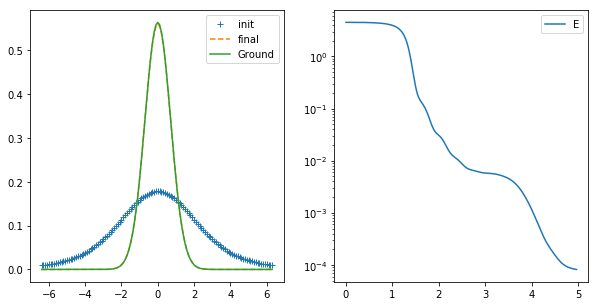

Wall time: 23.6 s


In [204]:
%%time 
args = dict(N=N, dx=dx,beta_V=beta_V, beta_K=0,  beta_D=0, beta_Y=0, T=5, divs=(1, 1), use_ABM=True, plt_log=True, check_dE=False)
psi = test_cooling(plot_dE=False, **args)

In [138]:
def test_cooling(plot_dE=True, use_ABM=False, T=0.5, **args):   
    b = BCSCooling(**args)
    solver = ABMEvolverAdapter if use_ABM else None
    h0 = HarmonicOscillator(w=1)
    h = HarmonicOscillator()
    da, db=b.divs    
    x = b.xyz[0]
    V = x**2/2
    H0 = b._get_H(mu_eff=0, V=0)
    H1 = b._get_H(mu_eff=0, V=V)
    U0, E0 = b.get_U_E(H0, transpose=True)
    U1, E1 = b.get_U_E(H1, transpose=True)
    psi0 = h.get_wf(x)
    psi0 = U1[0]
    psi0 = Normalize(psi0, dx=b.dx)
    psi = h0.get_wf(x, n=2)
    psi = random_gaussian_mixing(x) # U0[1]
    psi = Normalize(psi, dx=b.dx)
    #b.erase_max_ks()
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    N0 = psi0.conj().dot(psi0)
    ts, psiss = b.solve([psi], T=T, rtol=1e-5, atol=1e-6, V=V,solver=solver, method='BDF')
    E0, _ = b.get_E_Ns([psi0], V=V)
    Es = [b.get_E_Ns([_psi], V=V)[0] for _psi in psiss[0]]   
    plt.plot(x, Prob(psiss[0][0]), "+", label='init')
    plt.plot(x, Prob(psiss[0][-1]), '--',label="final")
    plt.plot(x, Prob(psi0), label='Ground')
    plt.legend()
    plt.subplot(1,2,2)
    plt.semilogy(ts[0][:-2], (Es[:-2] - E0)/abs(E0), label="E")
    if plot_dE:
        dE_dt= [-1*b.get_dE_dt([_psi], V=V) for _psi in psiss[0]]
        plt.plot(ts[0][:-2], dE_dt[:-2], label='-dE/dt')
        plt.axhline(0, linestyle='dashed')
    plt.legend()
    plt.axhline(0, linestyle='dashed')
    plt.show()    
    return psiss[0][-1]

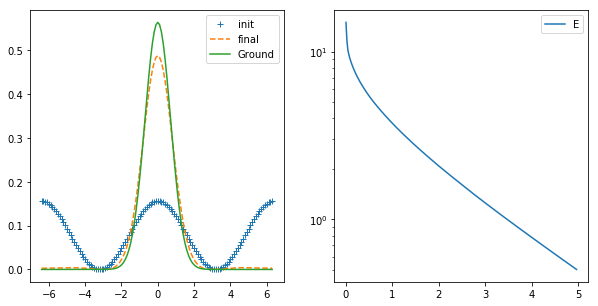

Wall time: 30.3 s


In [115]:
%%time 
args = dict(N=N, dx=dx, beta_0=1, beta_K=130, beta_V=0, beta_D=0, beta_Y=0, T=5, divs=(1, 1), use_ABM=True, check_dE=False)
psi = test_cooling(plot_dE=False, **args)

In [80]:
def Cooling(plot_dE=True, use_ABM=False, T=0.5, **args):
    b = BCSCooling(**args)
    solver = ABMEvolverAdapter if use_ABM else None
    h0 = HarmonicOscillator(w=1)
    h = HarmonicOscillator()
    da, db=b.divs    
    x = b.xyz[0]
    V =  x**2/2
    psi_0 = Normalize(np.sqrt(1.0 + 0.2*x*np.exp(-x**2)))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    ts, psiss = b.solve([psi_0], T=T, rtol=1e-5, atol=1e-6, V=V,solver=solver, method='BDF')
    psi0 = h0.get_wf(x=x, n=0)
    N0 = psi0.conj().dot(psi0)
    Ns = [_psi.conj().dot(_psi) for _psi in psiss[0]]
    E0, _ = b.get_E_Ns([psi0], V=V)
    Es = [b.get_E_Ns([_psi], V=V)[0] for _psi in psiss[0]]
    dE_dt= [-1*b.get_dE_dt([_psi], V=V) for _psi in psiss[0]]
    plt.plot(x, Prob(psiss[0][0]), "+", label='init')
    plt.plot(x, Prob(psiss[0][-1]), '--',label="final")
    plt.plot(x, Prob(psi0), label='Ground')
    plt.legend()
    plt.subplot(1,2,2)
    plt.semilogy(ts[0][:-2], (Es[:-2] - E0)/abs(E0), label="E")
    if plot_dE:
        plt.plot(ts[0][:-2], dE_dt[:-2], label='-dE/dt')
        plt.axhline(0, linestyle='dashed')
    plt.legend()
    plt.axhline(0, linestyle='dashed')
    plt.show()    
    return psiss[0][-1]

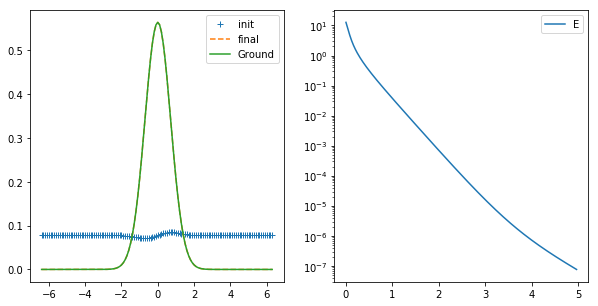

Wall time: 17 s


In [81]:
%%time 
args = dict(N=128, dx=0.1,beta_0=-1j, beta_K=0, beta_V=0, beta_D=0, beta_Y=0, T=5, divs=(1, 1), use_ABM=True, check_dE=False)
psi = Cooling(plot_dE=False, **args)

In [6]:
args = dict(N=4, g=1)
egs = [BCSCooling(beta_0=-1j, beta_V=0.0, beta_K=0.0, **args),
       BCSCooling(beta_0=0.0, beta_V=0.0, beta_K=1.0, **args),
       BCSCooling(beta_0=1.0, beta_V=0.0, beta_K=1.0, **args),      
       BCSCooling(beta_0=0.0, beta_V=1.0, beta_K=0.0, **args),
       BCSCooling(beta_0=1.0, beta_V=1.0, beta_K=0.0, **args),
       BCSCooling(beta_0=0.0, beta_V=1.0, beta_K=1.0, **args),
       BCSCooling(beta_0=1.0, beta_V=1.0, beta_K=1.0, **args)]
labels = ['Imaginary Time',
          'K', 'H+K',
          'V', 'H+V',
          'V+K', 'H+V+K']
eg = egs[0]
psi0 = 2*(np.random.random(eg.Nxyz[0]) + 1j*np.random.random(eg.Nxyz[0]) - 0.5 - 0.5j)
V = np.array(psi0)*0
x=egs[0].xyz[0]
#psi0 = 0*x + 1.5 + 1.5*np.exp(-x**2/2)
psi_ground = 0*psi0 + np.sqrt((abs(psi0)**2).mean())
E0, N0 = eg.get_E_Ns([psi_ground], V=V)
Es = [[] for _n in range(len(egs))]
psis = [psi0.copy() for _n in range(len(egs))]
t_max = 3.0
Nstep = 4
Ndata = int(np.round(t_max/eg.dt/Nstep))
ts = np.arange(Ndata)*Nstep*eg.dt
for _n in range(Ndata):
    for n, eg in enumerate(egs):
        ps = [psis[n]]
        ps = eg.step(psis=ps, n=Nstep, V=V)
        psis[n] = ps[0]
        E, N = eg.get_E_Ns(psis=ps, V=V) 
        Es[n].append(E/E0 - 1.0)
Es = np.asarray(Es)

c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


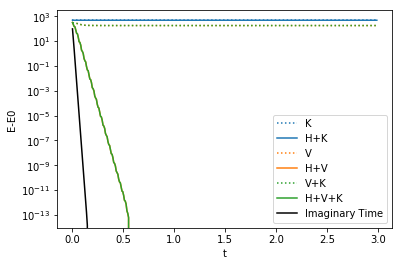

In [7]:
plt.semilogy(ts, Es[1], c='C0', ls=':', label=labels[1])
plt.semilogy(ts, Es[2], c='C0', ls='-', label=labels[2])
plt.semilogy(ts, Es[3], c='C1', ls=':', label=labels[3])
plt.semilogy(ts, Es[4], c='C1', ls='-', label=labels[4])
plt.semilogy(ts, Es[5], c='C2', ls=':', label=labels[5])
plt.semilogy(ts, Es[6], c='C2', ls='-', label=labels[6])
plt.semilogy(ts, Es[0], c='k', ls='-', label=labels[0], scaley=False)
plt.xlabel("t")
plt.ylabel("E-E0")
plt.legend()